In [2]:
import platform
import PIL  # Pillow 包通常在 Python 中以 PIL 名称导入
import jupyterlab
import matplotlib
import ipympl
# 打印 Python 版本
print("Python version:", platform.python_version())

# 打印 Pillow 版本
print("Pillow version:", PIL.__version__)

# 打印 JupyterLab 版本
print("JupyterLab version:", jupyterlab.__version__)

# 打印 matplotlib 版本
print("matplotlib version:", matplotlib.__version__)

# 打印 ipympl 版本
print("ipympl version:", ipympl.__version__)




Python version: 3.10.16
Pillow version: 11.1.0
JupyterLab version: 4.3.5
matplotlib version: 3.10.0
ipympl version: 0.9.6


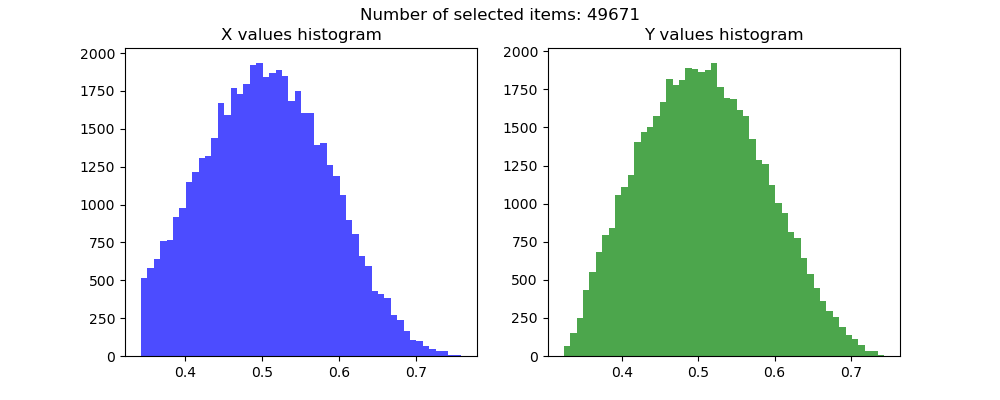

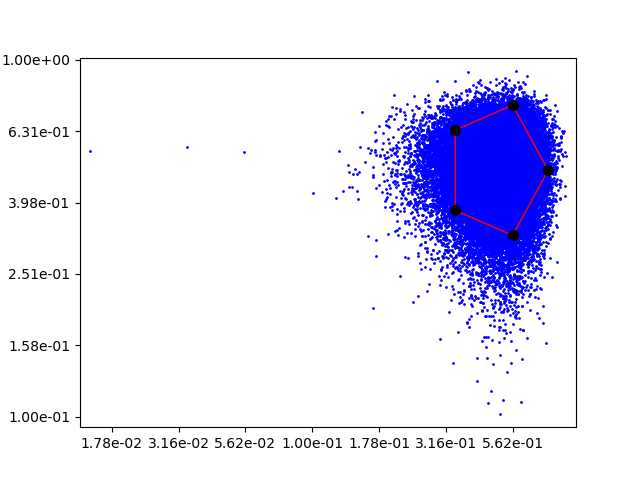

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Polygon
from matplotlib.ticker import FuncFormatter

class InteractivePolygonGating:
    def __init__(self, dataframe, x_col, y_col, num_edges=4, log=False):
        # Initialize with dataframe and column names to be used for plotting.
        self.df = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.num_edges = num_edges  # Number of polygon vertices
        self.log = log              # Whether to use logarithmic transformation
        self.selected_data = None   # Data selected by the polygon
        
        # Extract x and y arrays from the dataframe columns
        self.x = self.df[self.x_col].values
        self.y = self.df[self.y_col].values
        
        # Store original data ranges for later use
        self.x_min = self.x.min()
        self.x_max = self.x.max()
        self.y_min = self.y.min()
        self.y_max = self.y.max()
        
        # Apply log transformation if required
        if self.log:
            self.x_temp = np.log10(self.x)
            self.y_temp = np.log10(self.y)
        else:
            self.x_temp = self.x
            self.y_temp = self.y

        # Turn on interactive mode for matplotlib
        plt.ion()

        # Create figure and axis for scatter plot
        self.fig, self.ax = plt.subplots()
        self.ax.scatter(self.x_temp, self.y_temp, s=1, c='blue')

        # If using logarithmic scale, format tick labels to show original values in scientific notation
        if self.log:
            formatter = FuncFormatter(lambda val, pos: f"{10**val:.2e}")
            self.ax.xaxis.set_major_formatter(formatter)
            self.ax.yaxis.set_major_formatter(formatter)
            self.fig.canvas.draw_idle()

        # Set up the initial polygon vertices
        theta = np.linspace(0, 2*np.pi, self.num_edges, endpoint=False)
        # Determine radius as 20% of the smaller range from x_temp and y_temp
        xrange = self.x_temp.max() - self.x_temp.min()
        yrange = self.y_temp.max() - self.y_temp.min()
        radius = 0.2 * min(xrange, yrange)
        # Center the polygon on the data's mean position
        cx, cy = np.mean(self.x_temp), np.mean(self.y_temp)
        self.polygon_vertices = np.column_stack((radius*np.cos(theta) + cx,
                                                 radius*np.sin(theta) + cy))
        # Create a polygon patch using these vertices
        self.polygon = Polygon(self.polygon_vertices, closed=True,
                               linewidth=1, edgecolor='r', facecolor='none')
        self.ax.add_patch(self.polygon)

        # Draw the vertices with black color
        self.vertex_scatter = self.ax.scatter(self.polygon_vertices[:,0],
                                              self.polygon_vertices[:,1],
                                              s=50, c='black', zorder=3)

        # Set axis limits with an extra padding related to the polygon size
        pad = 0.2 * radius
        self.ax.set_xlim(self.x_temp.min() - pad, self.x_temp.max() + pad)
        self.ax.set_ylim(self.y_temp.min() - pad, self.y_temp.max() + pad)

        # Prepare histograms on a separate figure
        self.fig_hist, (self.ax_histx, self.ax_histy) = plt.subplots(1, 2, figsize=(10, 4))
        if self.log:
            # Use formatter to display histograms in scientific notation for log scale
            formatter = FuncFormatter(lambda val, pos: f"{10**val:,.0f}")
            self.ax_histx.xaxis.set_major_formatter(formatter)
            self.ax_histy.xaxis.set_major_formatter(formatter)

        self.dragging_vertex = None  # This will track which polygon vertex is being dragged

        # Update the histograms initially
        self.update_histograms()

        # Connect mouse events for interactive behavior
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

        plt.show(block=False)

    def on_press(self, event):
        # If click is outside the axis, ignore it
        if event.inaxes != self.ax:
            return
        # Get current axis limits for threshold calculation
        xlim = self.ax.get_xlim()
        ylim = self.ax.get_ylim()
        # Compute view's diagonal length
        diagonal = np.hypot(xlim[1] - xlim[0], ylim[1] - ylim[0])
        # Set a threshold (2% of diagonal) for selecting a vertex
        threshold = 0.02 * diagonal

        # Loop through vertices to see if the click is close enough to a vertex
        for i, (vx, vy) in enumerate(self.polygon.get_xy()):
            if np.hypot(event.xdata - vx, event.ydata - vy) < threshold:
                self.dragging_vertex = i
                break

    def on_release(self, event):
        # When mouse is released, stop dragging a vertex
        self.dragging_vertex = None
        # Update histograms based on new polygon position
        self.update_histograms()

    def on_motion(self, event):
        # If no vertex is selected or event is outside axis, ignore the motion
        if self.dragging_vertex is None or event.inaxes != self.ax:
            return
        # Update the position of the dragged vertex to follow the mouse
        self.polygon_vertices[self.dragging_vertex] = [event.xdata, event.ydata]
        self.polygon.set_xy(self.polygon_vertices)
        # Update the scatter points for vertices with new positions
        self.vertex_scatter.set_offsets(self.polygon_vertices)
        self.fig.canvas.draw()

    def update_histograms(self):
        # Determine which data points are enclosed by the polygon
        enclosed_indices = []
        path = Path(self.polygon.get_xy())
        for i in range(len(self.x_temp)):
            if path.contains_point((self.x_temp[i], self.y_temp[i])):
                enclosed_indices.append(i)
        # Save the selected data subset for use elsewhere
        self.selected_data = self.df.iloc[enclosed_indices]

        # Clear and update histogram for x values from the enclosed data
        self.ax_histx.clear()
        self.ax_histx.hist(self.x[enclosed_indices], bins=50, color='blue', alpha=0.7)
        self.ax_histx.set_title('X values histogram')

        # Clear and update histogram for y values from the enclosed data
        self.ax_histy.clear()
        self.ax_histy.hist(self.y[enclosed_indices], bins=50, color='green', alpha=0.7)
        self.ax_histy.set_title('Y values histogram')

        # Set the overall title with count of selected items and redraw the figure
        self.fig_hist.suptitle(f"Number of selected items: {len(enclosed_indices)}")
        self.fig_hist.canvas.draw()

    def apply_gate(self, new_df, x_col=None, y_col=None):
        # Apply current polygon gate to a new dataframe
        if x_col is None: 
            x_col = self.x_col
        if y_col is None: 
            y_col = self.y_col

        # Extract x and y values from the new dataframe
        new_x = new_df[x_col].values
        new_y = new_df[y_col].values

        # Apply log transformation if needed
        if self.log:
            new_x_temp = np.log10(new_x)
            new_y_temp = np.log10(new_y)
        else:
            new_x_temp = new_x
            new_y_temp = new_y

        # Determine which points in the new dataframe are inside the polygon
        path = Path(self.polygon.get_xy())
        enclosed_indices = []
        for i in range(len(new_x_temp)):
            if path.contains_point((new_x_temp[i], new_y_temp[i])):
                enclosed_indices.append(i)

        # Return only the points that are inside the polygon
        return new_df.iloc[enclosed_indices]


# Example usage:
if __name__ == "__main__":
    np.random.seed(0)
    # Generate sample data using normal distribution
    data = {
        'x': np.random.normal(0.5, 0.1, 60000),
        'y': np.random.normal(0.5, 0.1, 60000)
    }
    df = pd.DataFrame(data)

    # Create an instance of InteractivePolygonGating with 5 vertices and logarithmic scale enabled.
    gate1 = InteractivePolygonGating(df, 'x', 'y', num_edges=5, log=True)
    # As you drag the polygon the histograms and scatter plot will update.


In [25]:
gate1.selected_data

,x,y
19108,9.555337,10.051223
28660,9.534005,10.068811
54836,9.514788,10.053462


In [26]:
gate1.apply_gate(df)

,x,y
19108,9.555337,10.051223
28660,9.534005,10.068811
54836,9.514788,10.053462


In [44]:
gate1.apply_gate(df)

,x,y
19,0.597712,0.608730
73,0.542823,0.628994
80,0.552868,0.649878
88,0.566477,0.595360
106,0.661215,0.589709
...,...,...
59944,0.508264,0.594024
59950,0.642731,0.615691
59969,0.576778,0.625308
59972,0.596274,0.608475


          FSC-H         FSC-A         SSC-H         SSC-A        FL5-H  \
0  1.245440e+06  1.137749e+06  1.086676e+06  1.028578e+06   896.400024   
1  7.647308e+05  6.140952e+05  9.600986e+05  9.628853e+05   881.700012   
2  8.269922e+05  7.753288e+05  1.360484e+06  1.991305e+06  1384.400024   
3  7.939202e+05  6.101078e+05  3.554681e+05  3.603632e+05   584.400024   
4  6.853442e+05  5.623178e+05  4.422121e+05  4.119752e+05  1272.400024   

        FL5-A      FL11-H      FL11-A       FL8-H       FL8-A   FSC-Width  \
0  -62.700001  154.600006   67.500000  608.700012  356.299988  935.456116   
1 -147.800003  281.799988  322.899994  430.899994   27.700001  822.296021   
2  682.299988  506.600006  420.500000  352.700012   88.300003  960.029114   
3 -353.700012  330.600006   20.000000  312.700012   64.800003  786.918152   
4   26.299999  250.600006  137.000000  296.700012 -113.699997  840.181152   

           Time  
0  29919.144531  
1  30455.144531  
2  30782.144531  
3  31684.144531  
4 

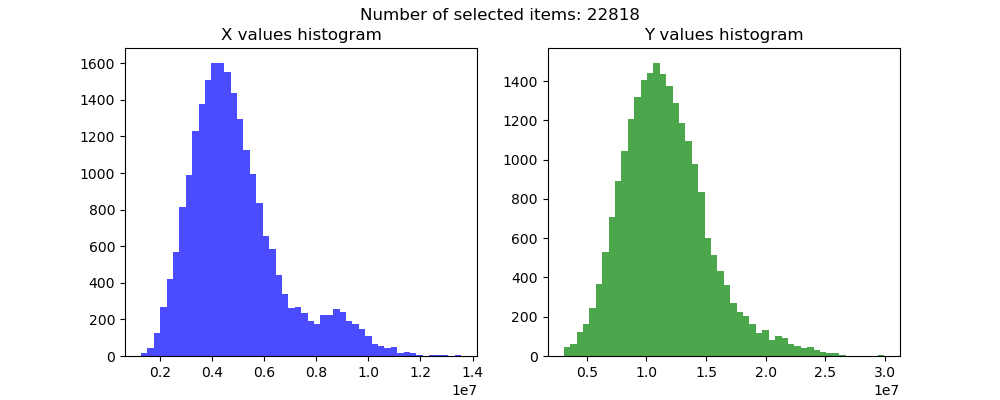

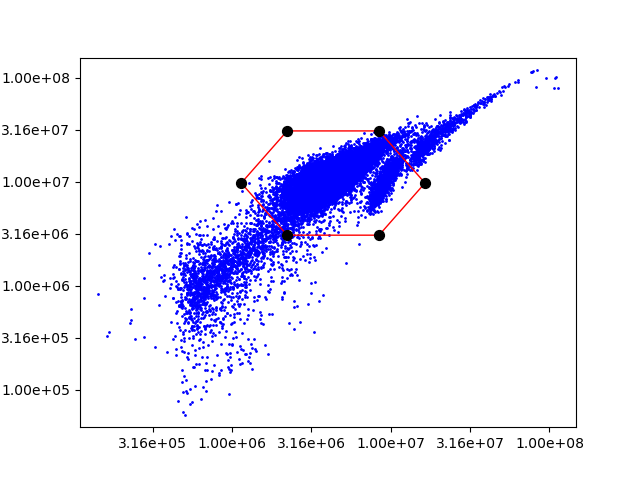

In [38]:
import FlowCal
import pandas as pd

# Read the .facs file
file_path = r'/Volumes/khammash/MC/cytoflex/Exp_20240417/Exp_20240417_1/data/01-016_high-G1.fcs'
data = FlowCal.io.FCSData(file_path)

# Convert to a pandas DataFrame
df = pd.DataFrame(data, columns=data.channels)
print(df.head())

# Filter the DataFrame

filtered_df = df[(df['FSC-A'] > 0) & (df['SSC-A'] > 0)]

# selector = InteractivePolygonSelector(df, 'FSC-A', 'SSC-A', num_edges=5, log_log=True)
gate1 = InteractivePolygonGating(filtered_df, 'FSC-A', 'SSC-A', num_edges=6, log=True)

In [28]:
gate1.selected_data

,FSC-H,FSC-A,SSC-H,SSC-A,FL5-H,FL5-A,FL11-H,FL11-A,FL8-H,FL8-A,FSC-Width,Time
0,1.245440e+06,1.137749e+06,1.086676e+06,1.028578e+06,896.400024,-62.700001,154.600006,67.500000,608.700012,356.299988,935.456116,2.991914e+04
1,7.647308e+05,6.140952e+05,9.600986e+05,9.628853e+05,881.700012,-147.800003,281.799988,322.899994,430.899994,27.700001,822.296021,3.045514e+04
2,8.269922e+05,7.753288e+05,1.360484e+06,1.991305e+06,1384.400024,682.299988,506.600006,420.500000,352.700012,88.300003,960.029114,3.078214e+04
3,7.939202e+05,6.101078e+05,3.554681e+05,3.603632e+05,584.400024,-353.700012,330.600006,20.000000,312.700012,64.800003,786.918152,3.168414e+04
4,6.853442e+05,5.623178e+05,4.422121e+05,4.119752e+05,1272.400024,26.299999,250.600006,137.000000,296.700012,-113.699997,840.181152,3.204914e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
25960,3.043412e+06,6.454713e+06,5.653064e+06,1.886864e+07,7204.700195,11239.299805,2832.100098,5274.299805,621.799988,608.700012,2171.784424,1.698905e+06
25961,2.122984e+06,3.956205e+06,5.651178e+06,1.432673e+07,6185.899902,9812.299805,1533.300049,2814.500000,419.000000,395.799988,1908.235229,1.698943e+06
25962,2.960856e+06,4.396826e+06,5.609652e+06,8.258806e+06,5631.700195,6293.700195,946.099976,1462.599976,414.600006,325.200012,1520.624023,1.699458e+06
25963,3.236555e+06,6.688398e+06,5.653456e+06,1.427288e+07,4781.500000,7572.899902,1426.099976,2293.199951,541.099976,279.100006,2116.115967,1.699500e+06


In [29]:
gate1.apply_gate(filtered_df)

,FSC-H,FSC-A,SSC-H,SSC-A,FL5-H,FL5-A,FL11-H,FL11-A,FL8-H,FL8-A,FSC-Width,Time
0,1.245440e+06,1.137749e+06,1.086676e+06,1.028578e+06,896.400024,-62.700001,154.600006,67.500000,608.700012,356.299988,935.456116,2.991914e+04
1,7.647308e+05,6.140952e+05,9.600986e+05,9.628853e+05,881.700012,-147.800003,281.799988,322.899994,430.899994,27.700001,822.296021,3.045514e+04
2,8.269922e+05,7.753288e+05,1.360484e+06,1.991305e+06,1384.400024,682.299988,506.600006,420.500000,352.700012,88.300003,960.029114,3.078214e+04
3,7.939202e+05,6.101078e+05,3.554681e+05,3.603632e+05,584.400024,-353.700012,330.600006,20.000000,312.700012,64.800003,786.918152,3.168414e+04
4,6.853442e+05,5.623178e+05,4.422121e+05,4.119752e+05,1272.400024,26.299999,250.600006,137.000000,296.700012,-113.699997,840.181152,3.204914e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
25960,3.043412e+06,6.454713e+06,5.653064e+06,1.886864e+07,7204.700195,11239.299805,2832.100098,5274.299805,621.799988,608.700012,2171.784424,1.698905e+06
25961,2.122984e+06,3.956205e+06,5.651178e+06,1.432673e+07,6185.899902,9812.299805,1533.300049,2814.500000,419.000000,395.799988,1908.235229,1.698943e+06
25962,2.960856e+06,4.396826e+06,5.609652e+06,8.258806e+06,5631.700195,6293.700195,946.099976,1462.599976,414.600006,325.200012,1520.624023,1.699458e+06
25963,3.236555e+06,6.688398e+06,5.653456e+06,1.427288e+07,4781.500000,7572.899902,1426.099976,2293.199951,541.099976,279.100006,2116.115967,1.699500e+06


In [4]:
df2 = gate1.selected_data
df2


,FSC-H,FSC-A,SSC-H,SSC-A,FL5-H,FL5-A,FL11-H,FL11-A,FL8-H,FL8-A,FSC-Width,Time
0,1.245440e+06,0.010112,1.086676e+06,0.008615,896.400024,-62.700001,154.600006,67.500000,608.700012,356.299988,935.456116,2.991914e+04
1,7.647308e+05,0.005458,9.600986e+05,0.008065,881.700012,-147.800003,281.799988,322.899994,430.899994,27.700001,822.296021,3.045514e+04
2,8.269922e+05,0.006891,1.360484e+06,0.016679,1384.400024,682.299988,506.600006,420.500000,352.700012,88.300003,960.029114,3.078214e+04
3,7.939202e+05,0.005423,3.554681e+05,0.003018,584.400024,-353.700012,330.600006,20.000000,312.700012,64.800003,786.918152,3.168414e+04
4,6.853442e+05,0.004998,4.422121e+05,0.003451,1272.400024,26.299999,250.600006,137.000000,296.700012,-113.699997,840.181152,3.204914e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
25960,3.043412e+06,0.057368,5.653064e+06,0.158038,7204.700195,11239.299805,2832.100098,5274.299805,621.799988,608.700012,2171.784424,1.698905e+06
25961,2.122984e+06,0.035162,5.651178e+06,0.119996,6185.899902,9812.299805,1533.300049,2814.500000,419.000000,395.799988,1908.235229,1.698943e+06
25962,2.960856e+06,0.039078,5.609652e+06,0.069173,5631.700195,6293.700195,946.099976,1462.599976,414.600006,325.200012,1520.624023,1.699458e+06
25963,3.236555e+06,0.059445,5.653456e+06,0.119545,4781.500000,7572.899902,1426.099976,2293.199951,541.099976,279.100006,2116.115967,1.699500e+06


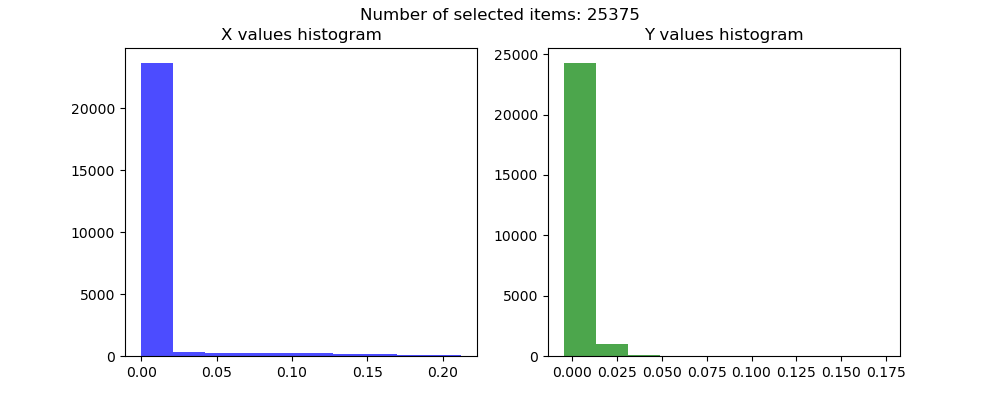

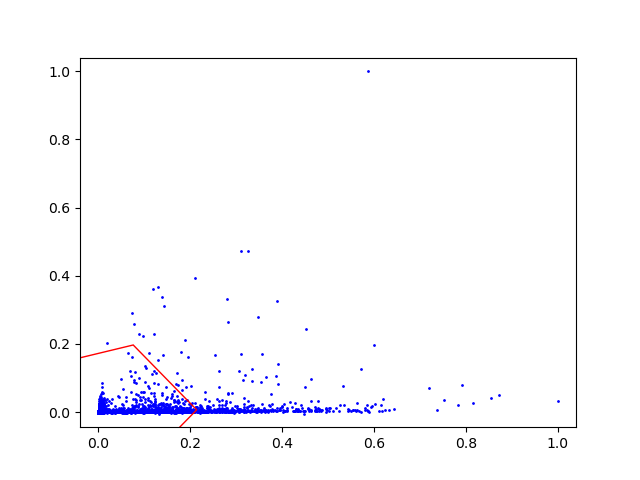

In [5]:
gate2 = InteractivePolygonGating(df2, 'FL5-A', 'FL11-A', num_edges=5)

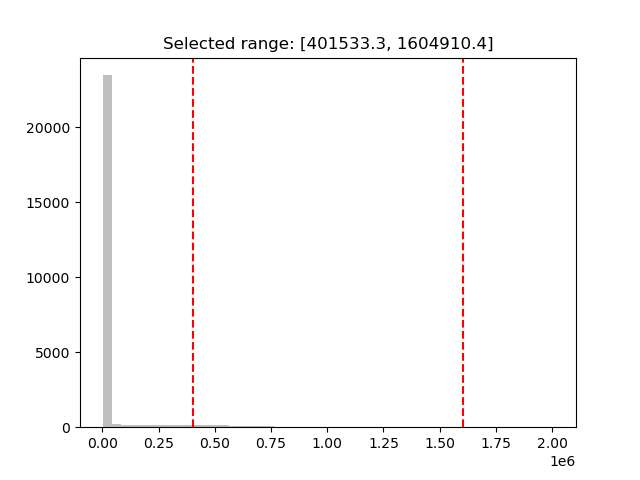

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class InteractiveHistogramThreshold:
    def __init__(self, data, channel, bins=50):
        self.data = data
        self.channel = channel
        self.bins = bins
        self.selected_data = None

        self.fig, self.ax = plt.subplots()
        self.hist_data, self.bins, _ = self.ax.hist(self.data[self.channel], bins=self.bins, alpha=0.5, color='gray')

        self.lower_line = self.ax.axvline(self.bins[10], color='red', linestyle='--')
        self.upper_line = self.ax.axvline(self.bins[40], color='red', linestyle='--')

        self.dragging_line = None

        self.update_title()

        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

        plt.show()

    def update_title(self):
        low = self.lower_line.get_xdata()[0]
        high = self.upper_line.get_xdata()[0]
        self.ax.set_title(f"Selected range: [{low:.1f}, {high:.1f}]")
        self.fig.canvas.draw_idle()

    def on_press(self, event):
        if event.inaxes != self.ax:
            return
        x = event.xdata
        if abs(x - self.lower_line.get_xdata()[0]) < 5e4:
            self.dragging_line = self.lower_line
        elif abs(x - self.upper_line.get_xdata()[0]) < 5e4:
            self.dragging_line = self.upper_line

    def on_release(self, event):
        self.dragging_line = None
        self.update_selected_data()

    def on_motion(self, event):
        if self.dragging_line is None or event.inaxes != self.ax or not event.xdata:
            return
        self.dragging_line.set_xdata([event.xdata, event.xdata])
        self.update_title()

    def update_selected_data(self):
        low = self.lower_line.get_xdata()[0]
        high = self.upper_line.get_xdata()[0]
        self.selected_data = self.data[(self.data[self.channel] >= low) & (self.data[self.channel] <= high)]
        print(f"Number of selected items: {len(self.selected_data)}")
        
    def plot_selected_data(self):
        fig, ax = plt.subplots()
        ax.hist(self.selected_data[self.channel], bins=self.bins, alpha=0.5, color='blue')
        ax.set_title(f"Selected Data Histogram for {self.channel}")
        plt.show()

# Example usage:
if __name__ == "__main__":
#     np.random.seed(0)
#     data = pd.DataFrame({
#         'channel': np.random.normal(128, 25, 10000).clip(0, 255)
#     })
    gating3 = InteractiveHistogramThreshold(df, 'FL5-H')
    # gating = InteractiveHistogramThreshold(data, 'channel')
    # Now gating.selected_data updates as you drag the lines.

Number of selected items: 109


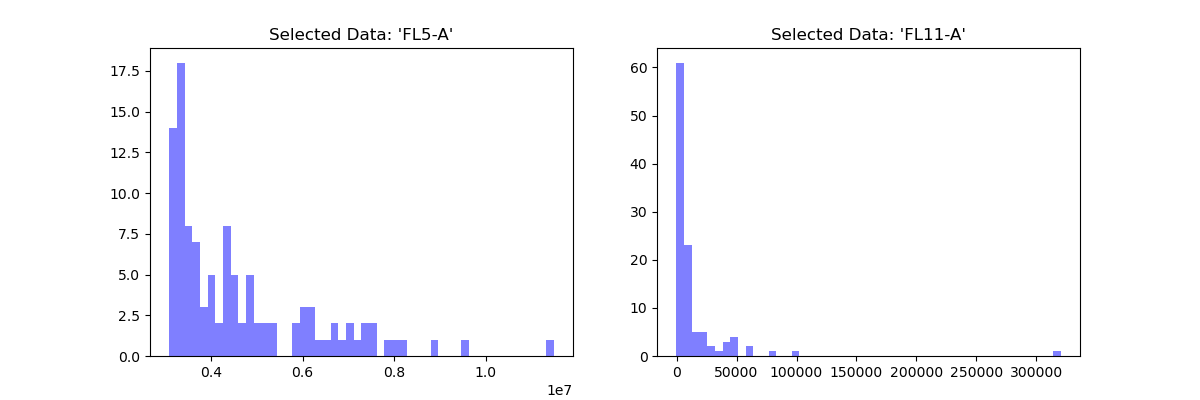

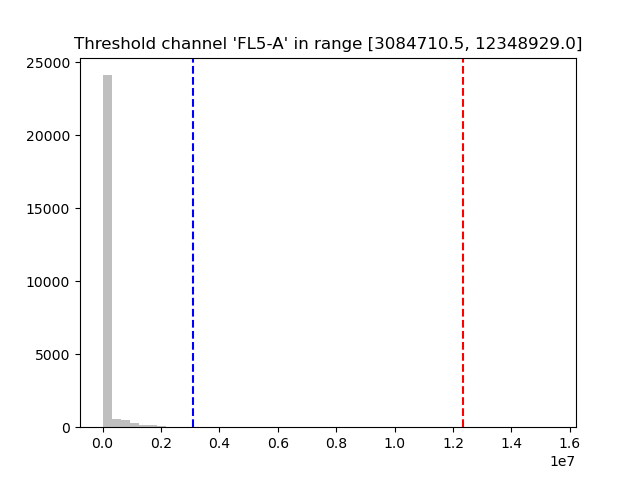

In [43]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class InteractiveHistogramThreshold:
    def __init__(self, data, threshold_channel, plot_channels, bins=50):
        """
        data: Pandas DataFrame containing all required channels.
        threshold_channel: The channel used for threshold selection.
        plot_channels: A list of channels to visualize from the selected data.
        bins: Number of bins for histogram.
        """
        self.data = data
        self.threshold_channel = threshold_channel
        # Ensure plot_channels is a list
        self.plot_channels = plot_channels if isinstance(plot_channels, list) else [plot_channels]
        self.bins = bins

        # Validate threshold channel
        if self.threshold_channel not in data.columns:
            raise ValueError(f"'{self.threshold_channel}' not found in the DataFrame columns.")

        # Validate plot channels
        for ch in self.plot_channels:
            if ch not in data.columns:
                raise ValueError(f"'{ch}' is not in the DataFrame columns.")

        self.selected_data = None

        # Main figure for threshold channel
        self.fig, self.ax = plt.subplots()
        self.hist_data, self.bin_edges, _ = self.ax.hist(
            self.data[self.threshold_channel],
            bins=self.bins,
            alpha=0.5,
            color='gray'
        )

        # Add vertical threshold lines around 20% and 80% by default
        self.lower_line = self.ax.axvline(
            self.bin_edges[int(len(self.bin_edges) * 0.2)],
            color='blue',
            linestyle='--'
        )
        self.upper_line = self.ax.axvline(
            self.bin_edges[int(len(self.bin_edges) * 0.8)],
            color='red',
            linestyle='--'
        )

        # Set up interactive events
        self.dragging_line = None
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

        # Figure for plotting multiple channels
        n_channels = len(self.plot_channels)
        n_cols = n_channels
        n_rows = math.ceil(n_channels / n_cols)
        self.fig_selected, self.ax_selected = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
        self.ax_selected = np.array(self.ax_selected).reshape(-1) if n_channels > 1 else [self.ax_selected]

        self.update_title()
        self.update_selected_data()

        # Show all figures non-blocking
        plt.show(block=False)

    def update_title(self):
        low = self.lower_line.get_xdata()[0]
        high = self.upper_line.get_xdata()[0]
        self.ax.set_title(
            f"Threshold channel '{self.threshold_channel}' in range [{low:.1f}, {high:.1f}]"
        )
        self.fig.canvas.draw_idle()

    def on_press(self, event):
        if event.inaxes != self.ax or event.xdata is None:
            return
        x = event.xdata
        dist_lower = abs(x - self.lower_line.get_xdata()[0])
        dist_upper = abs(x - self.upper_line.get_xdata()[0])
        # Threshold for detecting if we're close enough to a line
        threshold = (self.bin_edges[-1] - self.bin_edges[0]) * 0.02

        if dist_lower < threshold:
            self.dragging_line = self.lower_line
        elif dist_upper < threshold:
            self.dragging_line = self.upper_line

    def on_release(self, event):
        self.dragging_line = None
        self.update_selected_data()

    def on_motion(self, event):
        if self.dragging_line is None or event.xdata is None or event.inaxes != self.ax:
            return
        self.dragging_line.set_xdata([event.xdata, event.xdata])
        self.update_title()

    def update_selected_data(self):
        low = self.lower_line.get_xdata()[0]
        high = self.upper_line.get_xdata()[0]
        self.selected_data = self.data[
            (self.data[self.threshold_channel] >= low) &
            (self.data[self.threshold_channel] <= high)
        ]
        print(f"Number of selected items: {len(self.selected_data)}")
        self.plot_selected_channels()

    def plot_selected_channels(self):
        # Clear subplots and re-plot for each channel in plot_channels
        for ax in self.ax_selected:
            ax.clear()

        for i, ch in enumerate(self.plot_channels):
            if i < len(self.ax_selected):
                ax_ch = self.ax_selected[i]
                if not self.selected_data.empty:
                    ax_ch.hist(self.selected_data[ch], bins=self.bins, alpha=0.5, color='blue')
                    ax_ch.set_title(f"Selected Data: '{ch}'")
                else:
                    ax_ch.set_title(f"No data selected for '{ch}'")

        self.fig_selected.canvas.draw_idle()

# Example usage:
if __name__ == "__main__":
    np.random.seed(42)
    columns = ['channelA', 'channelB', 'channelC', 'channelD', 'channelE']
    df = pd.DataFrame(
        np.random.normal(loc=128, scale=25, size=(10000, len(columns))).clip(0, 255),
        columns=columns
    )

    # threshold_channel is used to define the selection range
    # plot_channels is a list of channels you want to see from the selected data
    gating = InteractiveHistogramThreshold(
        data=filtered_df,
        threshold_channel='FL5-A',
        plot_channels=['FL5-A','FL11-A']
    )

In [42]:
df

,channelA,channelB,channelC,channelD,channelE
0,140.417854,124.543392,144.192213,166.075746,122.146166
1,122.146576,167.480320,147.185868,116.263140,141.564001
2,116.414558,116.356756,134.049057,80.167994,84.877054
3,113.942812,102.679222,135.856183,105.299398,92.692407
4,164.641219,122.355592,129.688205,92.381295,114.390432
...,...,...,...,...,...
9995,99.150865,134.643481,123.181754,166.177913,65.370328
9996,129.018183,138.834737,150.442092,131.583085,137.119882
9997,132.400797,138.993807,127.517950,180.904463,142.446113
9998,132.934737,109.546888,119.442683,165.753009,65.875603


In [24]:
gating.selected_data

,FSC-H,FSC-A,SSC-H,SSC-A,FL5-H,FL5-A,FL11-H,FL11-A,FL8-H,FL8-A,FSC-Width,Time
117,4065350.00,0.171689,5650366.0,0.210195,577115.62500,0.279659,48456.800781,0.332628,623.700012,742.099976,4865.739746,4.414014e+04
371,3894347.75,0.144535,5652633.5,0.203460,612058.62500,0.277343,608.799988,0.003064,403.500000,468.799988,4276.067871,6.560514e+04
394,3880726.00,0.092998,5364470.0,0.094322,803004.62500,0.253435,643.200012,0.004303,335.799988,50.500000,2761.006104,6.657114e+04
667,4008568.50,0.143337,5653006.5,0.198920,590247.81250,0.263184,7057.799805,0.073066,671.099976,882.000000,4119.775391,8.218314e+04
711,3999082.00,0.197424,5653311.0,0.291013,412346.18750,0.253822,859.400024,0.004557,438.799988,-63.599998,5687.811035,8.969414e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
24369,3884673.00,0.136967,5616750.5,0.184314,546970.37500,0.290444,331.700012,0.001293,362.899994,-74.199997,4062.259766,1.531376e+06
25013,3984417.00,0.089998,5651461.0,0.127329,842206.87500,0.238437,496.799988,0.001370,306.500000,-130.800003,2602.401611,1.596802e+06
25244,4001289.50,0.177220,5652188.5,0.259134,549648.00000,0.253311,23466.099609,0.168445,517.799988,724.700012,5102.917480,1.613712e+06
25707,4040102.00,0.139981,5649400.0,0.197466,750443.37500,0.269510,720.700012,0.003173,502.399994,238.300003,3991.932373,1.670869e+06
